In [1]:
%cd ../..

/home/eli/AnacondaProjects/epych


In [2]:
import collections
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import quantities as pq
import scipy.io as sio

import epych


Syncopy 2023.9

See https://syncopy.org for the online documentation.
For bug reports etc. please send an email to syncopy@esi-frankfurt.de

Logging to log directory '/home/eli/.spy/logs'.
Temporary storage directory set to '/home/eli/.spy/tmp_storage'.



In [3]:
%matplotlib inline

In [4]:
data = sio.loadmat('/mnt/data/LabAssignment/data.mat', simplify_cells=True, struct_as_record=False)

/home/eli/miniforge3/envs/ephys/lib/python3.11/site-packages/scipy/io/matlab/_mio.py:227: MatReadWarning: Duplicate variable name "None" in stream - replacing previous with new
Considerscipy.io.matlab._mio5.varmats_from_mat to split file into single variable files
  matfile_dict = MR.get_variables(variable_names)


In [5]:
electrode_info = pd.read_csv('/mnt/data/LabAssignment/electrodeInfo.csv')

In [6]:
trial_info = pd.read_csv('/mnt/data/LabAssignment/trialInfo.csv').set_index("trial")

In [7]:
trial_info.columns

Index(['task', 'cueType', 'isSwitch', 'blockNum', 'sample', 'dist1', 'dist2',
       'targetLoc', 'dist1Loc', 'dist2Loc', 'responseLoc', 'outcome',
       'correct', 'reactionTime', 'trialStart', 'fixptOn', 'fixationTime',
       'sampleOn', 'sampleOff', 'testOn', 'responseDone', 'session',
       'trialRefTimes', 'badTimingTrials', 'badTrials'],
      dtype='object')

In [8]:
event_units = collections.defaultdict(lambda: None, trialStart=pq.second, fixptOn=pq.second, fixationTime=pq.second,
                                      sampleOn=pq.second, sampleOff=pq.second, testOn=pq.second, responseDone=pq.second,
                                      start=pq.second, end=pq.second)

In [9]:
dt = data['lfpSchema']['smpInterval'][0] * pq.second

In [10]:
times = data['lfpSchema']['index'][0] * pq.second

In [11]:
lfp = epych.signals.lfp.EpochedLfp(electrode_info, data['lfp'].swapaxes(0, 1) * pq.volt, dt, times)

In [12]:
series = epych.recording.Sampling(pd.DataFrame(columns=["trial", "type", "start", "end"]), trial_info, event_units, lfp=lfp)

In [13]:
trials = series.select_trials(series.trials["badTrials"] == 1)

In [14]:
cued_lfp = trials.time_lock(trials.trials['sampleOn'].mean(), before=0.5, after=0.5).signals['lfp']

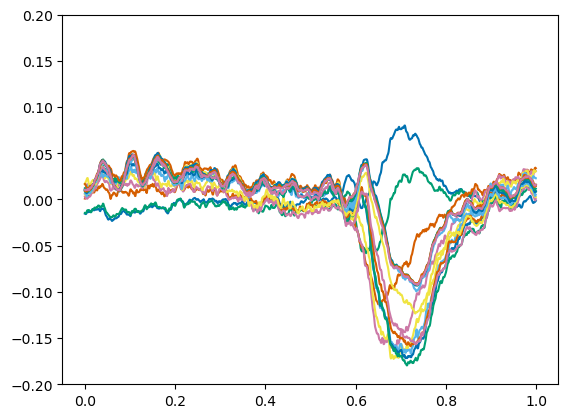

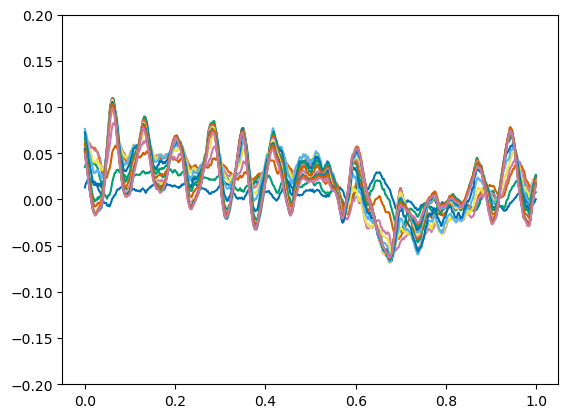

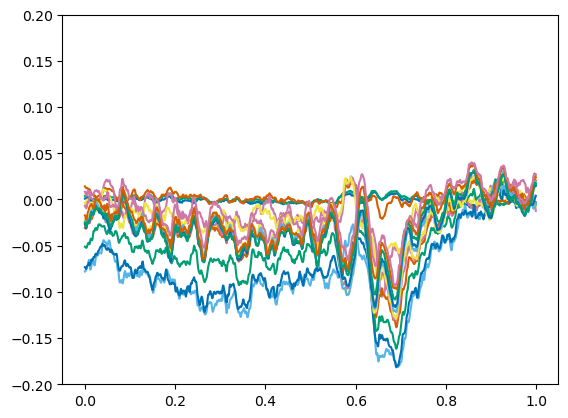

In [15]:
for area in ['VLPFC1', '7A', 'V4 Foveal']:
    lfp = cued_lfp.select_channels(cued_lfp.channels['area'] == area)
    erp = lfp.evoked()

    ax = plt.gca()
    erp.line_plot()
    ax.set_ylim(bottom=-0.2, top=0.2)
    plt.show()

discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]

discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]


discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]

discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]


discrete filter coefficients: 
b

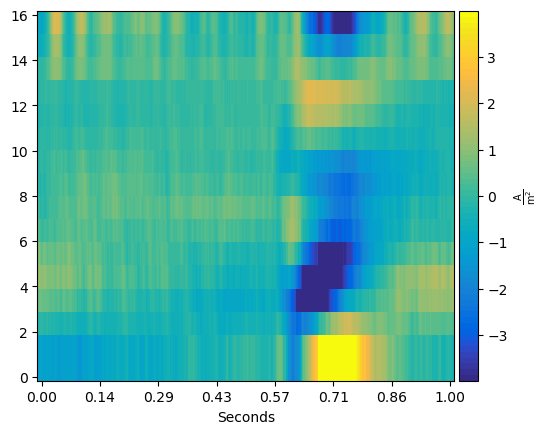

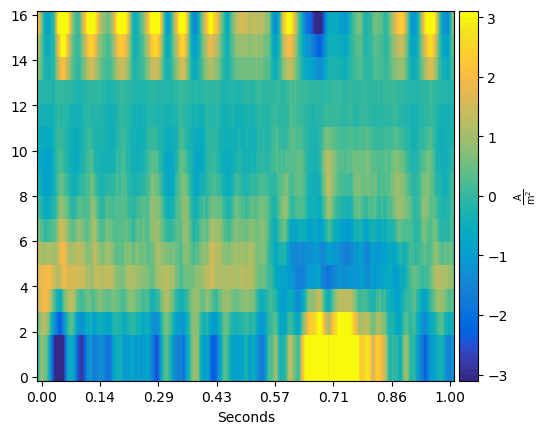

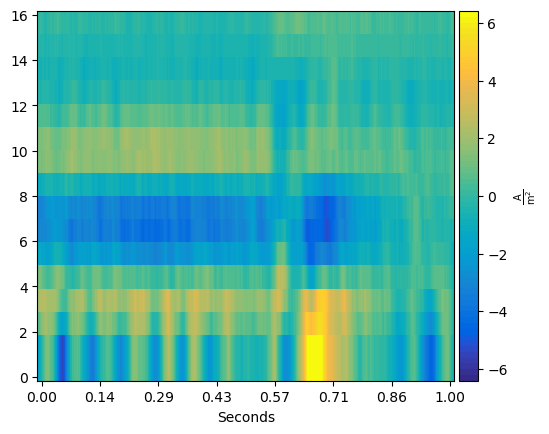

discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]


discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]

discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]

discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]discrete filter coefficients: 
b =

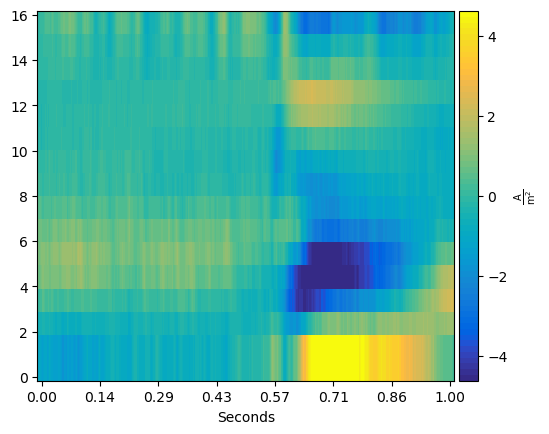

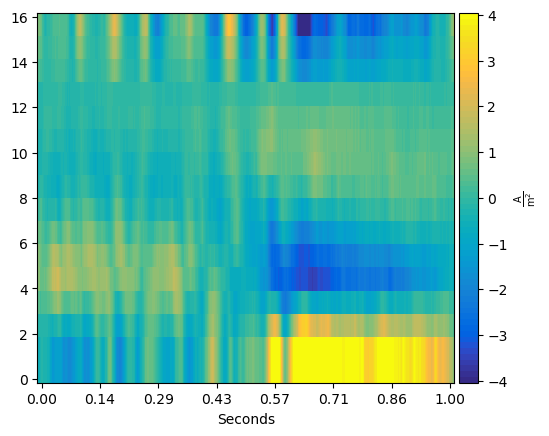

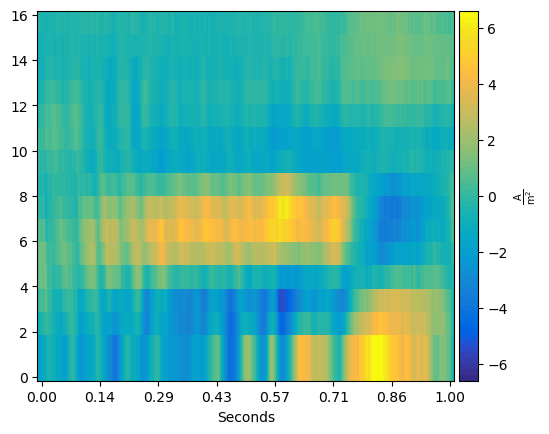

In [16]:
for event in ['sampleOn', 'testOn']:
    event_time = trials.trials[event].mean()
    event_csds = trials.time_lock(event_time, before=0.5, after=0.5).signals['lfp'].current_source_density(depth_column=None, method="StandardCSD")
    for area in ['VLPFC1', '7A', 'V4 Foveal']:
        csd = event_csds.select_channels(event_csds.channels['area'] == area).evoked()
        csd.plot()
        ax = plt.gca()
        # ax.set_ylim(bottom=-0.2, top=0.2)
        plt.show()

## 1 second pre-sample-onset to 1 second post-sample-onset (samples 501-2500)

In [17]:
cued_lfp = trials.time_lock(trials.trials['sampleOn'].mean(), before=1., after=1.).signals['lfp']

Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
17:58:42 - WARNING: Syncopy <input_processors> WARNING: option `t_ftimwin` has no effect for `MultiTaperFFT`!


/home/eli/miniforge3/envs/ephys/lib/python3.11/site-packages/syncopy/io/mne_conv.py:164: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  n_epochs = ea.get_data().shape[0]
/home/eli/miniforge3/envs/ephys/lib/python3.11/site-packages/syncopy/io/mne_conv.py:165: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  n_channels = ea.get_data().shape[1]
/home/eli/miniforge3/envs/ephys/lib/python3.11/site-packages/syncopy/io/mne_conv.py:166: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  n_times = ea.get_data().shape[2]
/home/eli/miniforge3/envs/ephys/lib/python3.11/site-packages/syncopy/io/mne_conv.py:170: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid 

  0% |          | 0/21 [00:00<?]

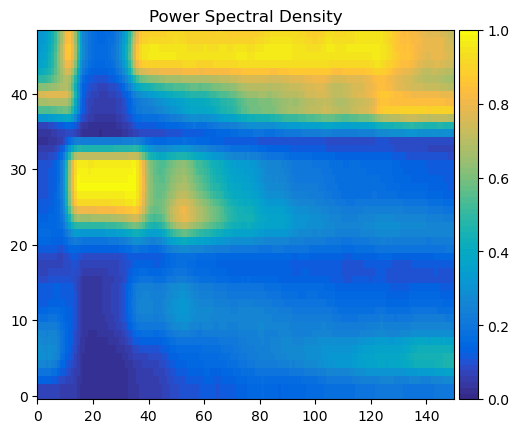

In [18]:
spectrum = epych.statistics.spectrum.PowerSpectrum(cued_lfp.df, cued_lfp.channels, cued_lfp.f0, taper="hann")
spectrum.calculate([cued_lfp])
spectrum.relative().evoked().heatmap(fbottom=0., ftop=150.)

Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
17:58:43 - WARNING: Syncopy <input_processors> WARNING: option `t_ftimwin` has no effect for `MultiTaperFFT`!


/home/eli/miniforge3/envs/ephys/lib/python3.11/site-packages/syncopy/io/mne_conv.py:164: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  n_epochs = ea.get_data().shape[0]
/home/eli/miniforge3/envs/ephys/lib/python3.11/site-packages/syncopy/io/mne_conv.py:165: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  n_channels = ea.get_data().shape[1]
/home/eli/miniforge3/envs/ephys/lib/python3.11/site-packages/syncopy/io/mne_conv.py:166: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  n_times = ea.get_data().shape[2]
/home/eli/miniforge3/envs/ephys/lib/python3.11/site-packages/syncopy/io/mne_conv.py:170: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid 

  0% |          | 0/21 [00:00<?]

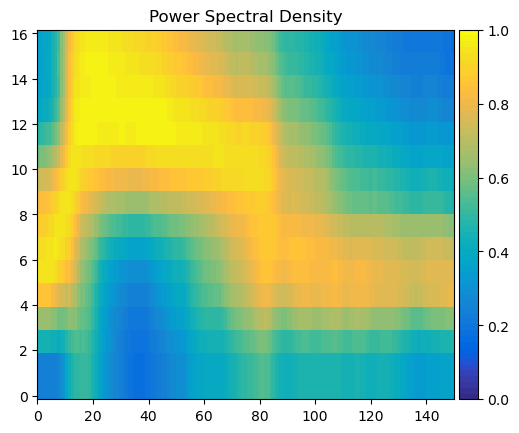

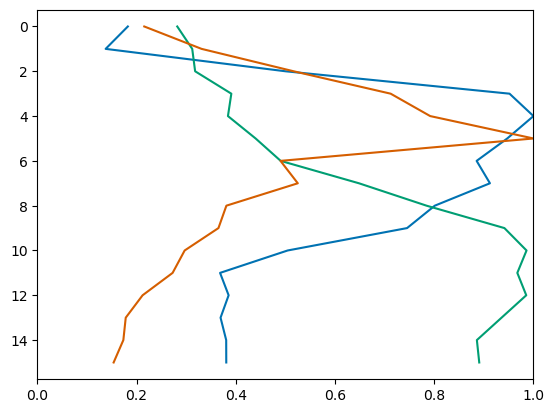

Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
17:58:43 - WARNING: Syncopy <input_processors> WARNING: option `t_ftimwin` has no effect for `MultiTaperFFT`!


/home/eli/miniforge3/envs/ephys/lib/python3.11/site-packages/syncopy/io/mne_conv.py:164: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  n_epochs = ea.get_data().shape[0]
/home/eli/miniforge3/envs/ephys/lib/python3.11/site-packages/syncopy/io/mne_conv.py:165: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  n_channels = ea.get_data().shape[1]
/home/eli/miniforge3/envs/ephys/lib/python3.11/site-packages/syncopy/io/mne_conv.py:166: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  n_times = ea.get_data().shape[2]
/home/eli/miniforge3/envs/ephys/lib/python3.11/site-packages/syncopy/io/mne_conv.py:170: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid 

  0% |          | 0/21 [00:00<?]

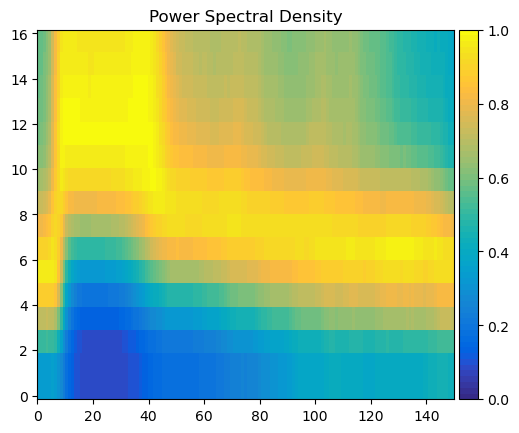

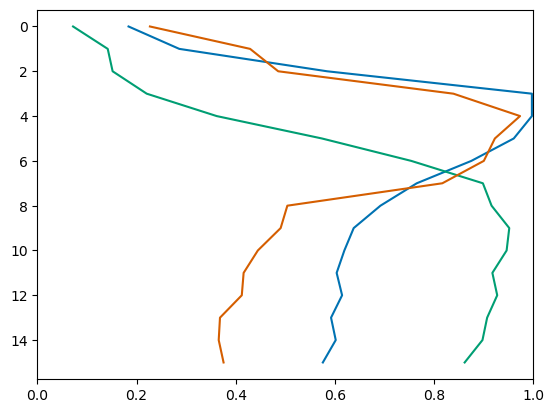

Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
17:58:44 - WARNING: Syncopy <input_processors> WARNING: option `t_ftimwin` has no effect for `MultiTaperFFT`!


/home/eli/miniforge3/envs/ephys/lib/python3.11/site-packages/syncopy/io/mne_conv.py:164: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  n_epochs = ea.get_data().shape[0]
/home/eli/miniforge3/envs/ephys/lib/python3.11/site-packages/syncopy/io/mne_conv.py:165: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  n_channels = ea.get_data().shape[1]
/home/eli/miniforge3/envs/ephys/lib/python3.11/site-packages/syncopy/io/mne_conv.py:166: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  n_times = ea.get_data().shape[2]
/home/eli/miniforge3/envs/ephys/lib/python3.11/site-packages/syncopy/io/mne_conv.py:170: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid 

  0% |          | 0/21 [00:00<?]

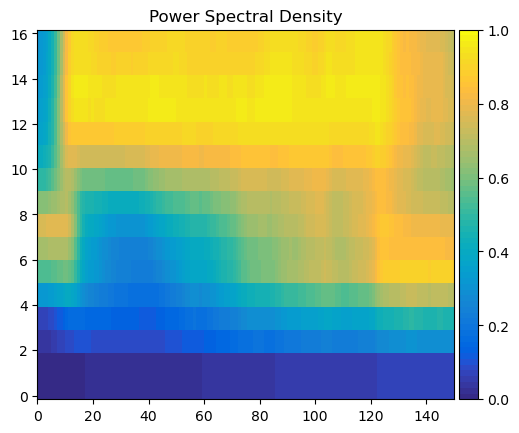

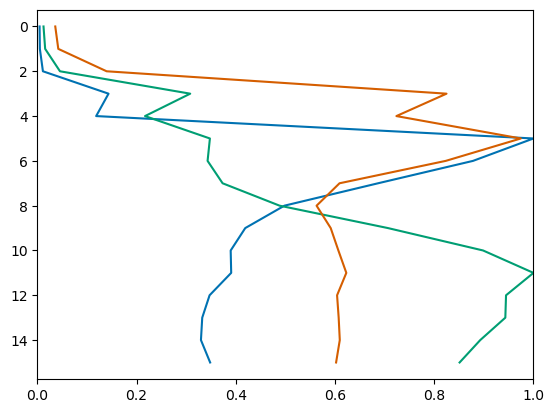

In [19]:
for area in ['VLPFC1', '7A', 'V4 Foveal']:
    lfp = cued_lfp.select_channels(cued_lfp.channels['area'] == area)
    spectrum = epych.statistics.spectrum.PowerSpectrum(lfp.df, lfp.channels, cued_lfp.f0, taper="hann")
    spectrum.calculate([lfp])
    spectrum = spectrum.relative().evoked()
    spectrum.heatmap(fbottom=0. * pq.Hz, ftop=150. * pq.Hz)
    plt.show()

    band_powers = [spectrum.band_power(*epych.statistics.spectrum.THETA_BAND),
                   spectrum.band_power(*epych.statistics.spectrum.ALPHA_BETA_BAND),
                   spectrum.band_power(*epych.statistics.spectrum.GAMMA_BAND)]

    for band in band_powers:
        spectrum.plot_channels(band, xlims=(0., 1.))
    plt.show()

In [20]:
sampleOns = trials.time_lock(trials.trials['sampleOn'].mean(), before=1., after=1.)

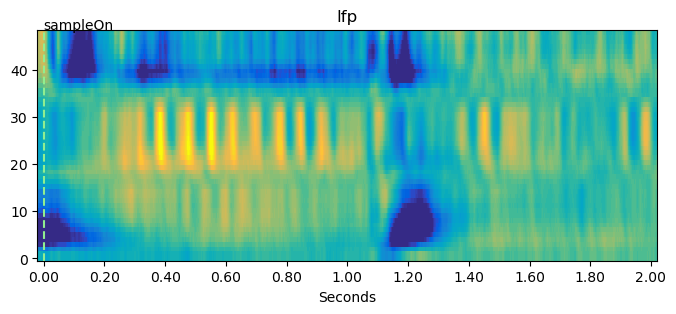

In [21]:
erp = sampleOns.erp()
erp.plot(vmin=-1e-1, vmax=1e-1, sampleOn=(erp.trials['sampleOn'].item(), "lightgreen"))